# Simple LSTM model

In [134]:
import os
import cntk as C
import numpy as np
import copy
import matplotlib.pyplot as plt
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components
%matplotlib inline

azureml_share_env = 'AZUREML_NATIVE_SHARE_DIRECTORY'
is_azure_ml = azureml_share_env in os.environ
share_path = os.environ[azureml_share_env] if is_azure_ml else '../../../'

all_path = os.path.join(share_path, "data/final/final.ctf")
train_path = os.path.join(share_path, "data/final/final.train.ctf")
val_path = os.path.join(share_path, "data/final/final.val.ctf")
test_path = os.path.join(share_path, "data/final/final.test.ctf")

test_path_tsv = os.path.join(share_path, "data/final/final.test.tsv")

print(C.__version__)

2.2


In [120]:
# Creates the reader
def create_reader(path, is_training, input_dim, label_dim):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        features = C.io.StreamDef(field='S0', shape=input_dim,   is_sparse=True),
        labels   = C.io.StreamDef(field='S1', shape=label_dim,   is_sparse=False)
    )), randomize=is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

# Defines the LSTM model for classifying sequences
def lstm_sequence_classifier(features, num_classes, embedding_dim, LSTM_dim):
    classifier = C.layers.Sequential([C.layers.Embedding(embedding_dim, name='embed'),
                                      C.layers.Recurrence(C.layers.LSTM(LSTM_dim), go_backwards=False),
                                      C.sequence.last,
                                      C.layers.Dense(num_classes, name='dense')])
    return classifier(features)

#### Train the model

In [140]:
class HistoryTracker(C.logging.TrainingSummaryProgressCallback):
    
    def __init__(self, epoch_size):
        def do_nothing():
            pass
        super(HistoryTracker, self).__init__(epoch_size, do_nothing)
        self.train_history = []
        self.test_history = []
    
    def on_write_training_summary(self, samples, updates, summaries, aggregate_loss, aggregate_metric, elapsed_milliseconds):
        self.train_history.append(aggregate_metric*1.0/samples)
        
    def on_write_test_summary(self, samples, updates, summaries, aggregate_metric, elapsed_milliseconds):
        self.test_history.append(aggregate_metric*1.0/samples)


def train(reader, reader_val, model, loss, metric, max_epochs=10):
    epoch_size = 9206 # Total number of sequences
    minibatch_size = 300 # Minimum number of tokens being fetched in a minibatch

    epoch_size_val = 1150

    progress_printer = C.logging.ProgressPrinter(freq=150,
                                                 tag='Training',
                                                 num_epochs=max_epochs)
    
    # epoch_size*20 is the estimate of the total number of tokens
    history_tracker = HistoryTracker(epoch_size*20)
    
    # SGD learner
    #lr_per_sample = C.learners.learning_rate_schedule(0.0015, C.learners.UnitType.sample)
    # learner = C.learners.sgd(model.parameters, lr=lr_per_sample)

    lr_schedule = C.learning_parameter_schedule([1.0]*3 + [0.8]*2 + [0.6]*1,
                                                 minibatch_size=C.learners.IGNORE,
                                                 epoch_size=epoch_size)
    t_schedule = C.momentum_schedule(0.971, minibatch_size=C.learners.IGNORE)
    learner = adadelta = C.adadelta(model.parameters, lr_schedule, 0.999, 1e-6)

    trainer = C.Trainer(model, (loss, metric),
                        learner,
                        [progress_printer, history_tracker])

    input_map = {
        features : reader.streams.features,
        labels   : reader.streams.labels
    }
    
    for epoch in range(max_epochs):
        # Train on one epoch
        t = 0
        while t < epoch_size:
            mb = reader.next_minibatch(minibatch_size, input_map=input_map)
            trainer.train_minibatch(mb)
            t += mb[labels].num_samples # Current number of read sequences
        trainer.summarize_training_progress()

        # Evaluate validation set after one epoch
        t = 0
        while t < epoch_size_val:
            mb = reader_val.next_minibatch(minibatch_size, input_map=input_map)
            trainer.test_minibatch(mb)
            t += mb[labels].num_samples

        trainer.summarize_test_progress()
    
    return (history_tracker.train_history, history_tracker.test_history)

In [141]:
vocab_size = 102200

# Model dimensions
input_dim = vocab_size
hidden_dim = 30
embedding_dim = 200
num_classes = 2

reader = create_reader(all_path, True, input_dim, num_classes)
reader_val = create_reader(val_path, True, input_dim, num_classes)

# Input variables denoting the features and label data
features = C.sequence.input_variable(shape=input_dim, is_sparse=True)
labels = C.input_variable(num_classes)

# Instantiate the sequence classification model
model_func = lstm_sequence_classifier(features, num_classes, embedding_dim, hidden_dim)
model = model_func(features)

# Create criterion
loss        = C.cross_entropy_with_softmax(model, labels)
label_error = C.classification_error(model, labels)

history = train(reader, reader_val, model, loss, label_error, max_epochs=6)

Learning rate per minibatch: 1.0
 Minibatch[   1- 150]: loss = 0.686283 * 2056, metric = 43.09% * 2056;
 Minibatch[ 151- 300]: loss = 0.601458 * 2069, metric = 31.90% * 2069;
 Minibatch[ 301- 450]: loss = 0.542409 * 2095, metric = 25.73% * 2095;
 Minibatch[ 451- 600]: loss = 0.499155 * 2116, metric = 22.78% * 2116;
Finished Epoch[1 of 6]: [Training] loss = 0.573511 * 9217, metric = 30.02% * 9217 14.841s (621.0 samples/s);
Finished Evaluation [1]: Minibatch[1-81]: metric = 17.72% * 1157;
 Minibatch[   1- 150]: loss = 0.484828 * 2160, metric = 21.16% * 2160;
 Minibatch[ 151- 300]: loss = 0.518389 * 2176, metric = 23.39% * 2176;
 Minibatch[ 301- 450]: loss = 0.452471 * 2151, metric = 19.76% * 2151;
 Minibatch[ 451- 600]: loss = 0.446716 * 2072, metric = 19.21% * 2072;
Finished Epoch[2 of 6]: [Training] loss = 0.474589 * 9210, metric = 20.81% * 9210 14.563s (632.4 samples/s);
Finished Evaluation [2]: Minibatch[1-81]: metric = 18.09% * 1150;
 Minibatch[   1- 150]: loss = 0.409597 * 2115, me

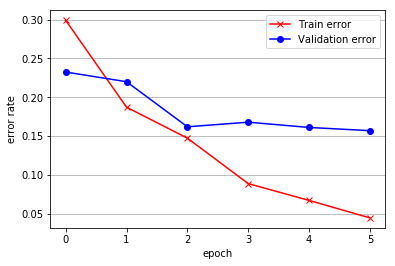

In [129]:
fig, ax = plt.subplots(1)
ax.plot(history[0], 'rx-', label='Train error')
ax.plot(history[1], 'bo-', label='Validation error')
ax.set_xlabel('epoch')
ax.set_ylabel('error rate')
ax.yaxis.grid('on')
ax.legend()

fig.savefig('outputs/train_history.png')


#### Test the model

In [132]:
reader_test = create_reader(test_path, False, input_dim, num_classes)

test_minibatch_size = 1000

input_map = {
    features : reader.streams.features,
    labels   : reader.streams.labels
}

progress_printer = C.logging.ProgressPrinter(tag='Evaluation', num_epochs=0)
evaluator = C.eval.Evaluator(label_error, progress_printer)

while True:
    mb = reader_test.next_minibatch(test_minibatch_size, input_map=input_map)
    if not mb:
        break
    eval_error = evaluator.test_minibatch(mb)

evaluator.summarize_test_progress()

Finished Evaluation [1]: Minibatch[1-35]: metric = 17.11% * 1677;


#### Save the model

In [143]:
model_path = 'outputs/model.cmf'
model.save(model_path)

#### Test the saved model

In [93]:
# Download the punkt corpus first
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [133]:
from preprocess.normalize_sentences import SentenceNormalizer
from cntk.ops.functions import load_model

saved_model = load_model(model_path)
vocab_size = 102200

with open('..\dictionary.txt', encoding='utf-8') as f:
    dictionary = f.read().split() 

sent_normalizer = SentenceNormalizer(dictionary=dictionary)
normalized = sent_normalizer.fit_transform(
    ["Donald Trump is a president.",
     "I think the earth is round"], to_index=True)

print(normalized)
pred_score = saved_model(C.Value.one_hot(normalized, vocab_size))
print(pred_score)

pred_class = np.argmax(pred_score, axis=1)
labels = []
with open('..\labels.txt', 'r', encoding='utf-8') as f:
    labels = f.read().strip().split('\n')
pred_class = [labels[p] for p in pred_class]
print(pred_class)


''
[[13218, 41200, 70817, 44810, 83672], [20219, 95890, 95666, 59893, 70817, 87976]]
[[ 0.3668181  -0.2832582 ]
 [-1.28273869  1.25848341]]
['objective', 'subjective']


In [142]:
from sklearn.metrics import classification_report
import pandas as pd

saved_model = load_model(model_path)
vocab_size = 102200

with open('..\dictionary.txt', encoding='utf-8') as f:
    dictionary = f.read().split() 

test_data = pd.read_csv(test_path_tsv, sep='\t')

sent_normalizer = SentenceNormalizer(dictionary=dictionary)
normalized = sent_normalizer.fit_transform(test_data['sentence'], to_index=True)

pred_score = saved_model(C.Value.one_hot(normalized, vocab_size))
pred_class = np.argmax(pred_score, axis=1)
labels = []
with open('..\labels.txt', 'r', encoding='utf-8') as f:
    labels = f.read().strip().split('\n')
pred_class = [labels[p] for p in pred_class]

print(classification_report(test_data['label'], pred_class, digits=4))


             precision    recall  f1-score   support

  objective     0.8225    0.8099    0.8162       784
 subjective     0.8354    0.8466    0.8409       893

avg / total     0.8294    0.8295    0.8294      1677

